In [44]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from celluloid import Camera
from IPython.display import HTML

import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Preprocessing

In [2]:
root = Path('../Datasets/Task02_Heart/imagesTr/')
labels = Path('../Datasets/Task02_Heart/labelsTr/')

In [3]:
Path(*root.parts)

PosixPath('../Datasets/Task02_Heart/imagesTr')

In [4]:
def change_to_label_path(path):
    
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [24]:
sample_path = list(root.glob('la*'))[0]
sample_path

PosixPath('../Datasets/Task02_Heart/imagesTr/la_011.nii.gz')

In [25]:
sample_path_label = change_to_label_path(sample_path)
sample_path_label

PosixPath('../Datasets/Task02_Heart/labelsTr/la_011.nii.gz')

In [27]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

In [45]:
mri.shape

(320, 320, 120)

In [46]:
mri[32:-32, 32:-32].shape

(256, 256, 120)

In [28]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

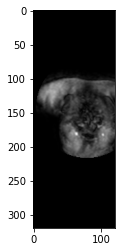

In [37]:
fig = plt.figure()
cam = Camera(fig)

for i in range(mri.shape[1]):
    plt.imshow(mri[:, i, :], cmap='gray')
    mask_ = np.ma.masked_where(mask[:, i, :]==0, mask[:, i, :])
    plt.imshow(mask_, alpha=0.7, cmap='autumn')
    cam.snap()
    
animation = cam.animate()

In [38]:
HTML(animation.to_html5_video())

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


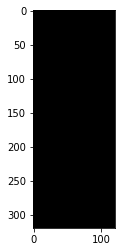

In [39]:
fig = plt.figure()
cam = Camera(fig)

for i in range(mri.shape[0]):
    plt.imshow(mri[i, :, :], cmap='gray')
    mask_ = np.ma.masked_where(mask[i, :, :]==0, mask[i, :, :])
    plt.imshow(mask_, alpha=0.7, cmap='autumn')
    cam.snap()
    
animation = cam.animate()

In [40]:
HTML(animation.to_html5_video())

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


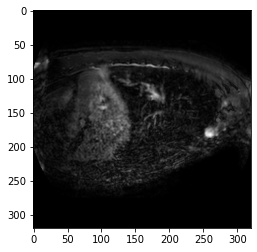

In [41]:
fig = plt.figure()
cam = Camera(fig)

for i in range(mri.shape[2]):
    plt.imshow(mri[:, :, i], cmap='gray')
    mask_ = np.ma.masked_where(mask[:, :, i]==0, mask[:, :, 1])
    plt.imshow(mask_, alpha=0.7, cmap='autumn')
    cam.snap()
    
animation = cam.animate()

In [42]:
HTML(animation.to_html5_video())

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


In [5]:
def normalize(volume):
    
    mu = volume.mean()
    std = np.std(volume)
    normalized  = (volume - mu) / std
    return normalized

def normalize_and_standardize(volume):
    normalized = normalize(volume)
    resulted = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return resulted

In [6]:
all_files = list(root.glob("la*"))
len(all_files)

20

In [50]:
save_root = Path("../Datasets/AturiumProcessed")

for c, path_to_vol in enumerate(tqdm(all_files)):
    
    path_to_label = change_to_label_path(path_to_vol)
    
    mri = nib.load(path_to_vol).get_fdata()
    label = nib.load(path_to_label).get_fdata().astype(np.uint8)
    
    mri = mri[32:-32, 32:-32]
    label = label[32:-32, 32:-32]
    
    norm_stand = normalize_and_standardize(mri)
    
    train_or_val = "train" if c < 17 else "val"
    
    for i in range(norm_stand.shape[-1]):
        sag_slice = norm_stand[:, :, i]
        mask = label[:, :, i]
        slice_path = save_root/train_or_val/str(c)/'data'
        mask_path = save_root/train_or_val/str(c)/'masks'
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)        
        
        np.save(slice_path/str(i), sag_slice)
        np.save(mask_path/str(i), mask)

100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  2.00it/s]


# Dataset

In [14]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        super().__init__()
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
        
    @staticmethod
    def extract_files(root):
        files = []
        
        for subject in root.glob('*'):
            slice_path = subject/'data'
            for slice_ in slice_path.glob("*.npy"):
                files.append(slice_)
        return files
    
    @staticmethod
    def change_to_label_path(path):
        parts = list(path.parts)
        parts[parts.index("data")] = 'masks'
        return Path(*parts)
    
    def augment(self, slce, mask):
        random_seed = torch.randint(0, 100000, (1, )).item()
        imgaug.seed(random_seed)
        
        mask = SegmentationMapOnImage(mask, mask.shape)
        slice_augmented, mask_augmented = self.augment_params(image=slce, segmentation_maps=mask)
        mask_augmented = mask_augmented.get_arr()
        return slice_augmented, mask_augmented
    
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        mask_path = self.change_to_label_path(file_path)
        
        slce = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)
        
        if self.augment_params:
            slce, mask = self.augment(slce, mask)
            
        return np.expand_dims(slce, 0), np.expand_dims(mask, 0)

In [15]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.8, 1.1), rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [16]:
path = Path("../Datasets/AturiumProcessed/train/")
dataset = CardiacDataset(path, seq)

In [17]:
len(dataset)

1941

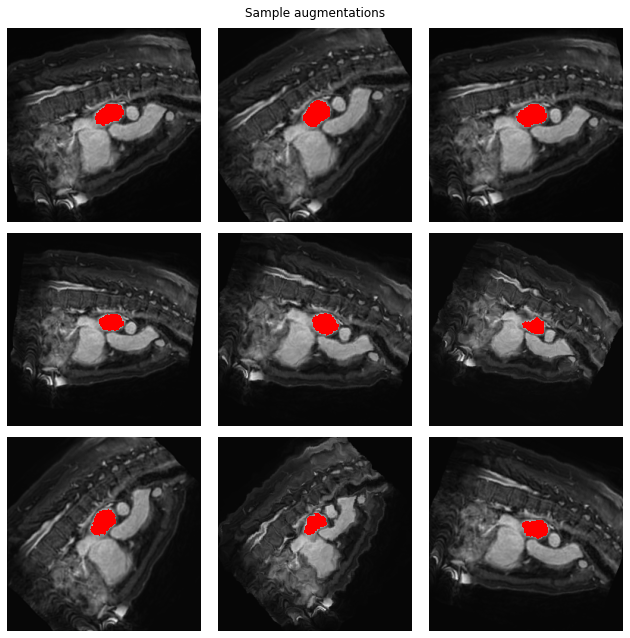

In [25]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slce, mask = dataset[3]
        mask_ = np.ma.masked_where(mask==0, mask)
        axs[i][j].imshow(slce[0], cmap='gray')
        axs[i][j].imshow(mask_[0], cmap='autumn')
        axs[i][j].axis('off')
fig.suptitle("Sample augmentations")  
plt.tight_layout() 

# Model Creation and Training

In [28]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.step = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
            torch.nn.ReLU()
        )
        
    def forward(self, X):
        return self.step(X)
    

class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)
        
        self.layer5 = DoubleConv(512+256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)
        
        self.maxpool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        x1 = self.layer1(x)
        xm1 = self.maxpool(x1)
        
        x2 = self.layer2(xm1)
        xm2 = self.maxpool(x2)
        
        x3 = self.layer3(xm2)
        xm3 = self.maxpool(x3)
        
        x4 = self.layer4(xm3)
        
        x5 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)
        
        x6 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)
        
        x7 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        
        ret = self.layer8(x7)
        return ret

In [30]:
model = UNet()
random_arr = torch.randn(1, 1, 256, 256)
output = model(random_arr)
output.shape

torch.Size([1, 1, 256, 256])

In [32]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, mask):
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        num = (pred * mask).sum()
        den = pred.sum() + mask.sum() + 1e-8
        dice = (2 * num) / den
        return 1 - dice

In [33]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Dice", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Dice", loss)
        
        if batch_idx % 5 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")
            
        return loss
    
    def log_images(self, mri, pred, mask, name):
        pred = pred > 0.5
        
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(mri[0][0], cmap='bone')
        mask_ = np.ma.masked_where(mask[0][0]==0, mask[0][0])
        axs[0].imshow(mask_, alpha=0.6)
        
        axs[1].imshow(mri[0][0], cmap='bone')
        mask_ = np.ma.masked_where(pred[0][0]==0, pred[0][0])
        axs[1].imshow(mask_, alpha=0.6)
        
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [34]:
torch.manual_seed(0)
model = AtriumSegmentation()

In [35]:
callback_checkpoint = ModelCheckpoint(
    monitor="Val Dice", dirpath='checkpoints/', filename="AtSeg-{epoch}-{Val Dice:.2f}",
    save_top_k=3, mode='min'
)

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory checkpoints/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [36]:
trainer = pl.Trainer(gpus=1, logger=TensorBoardLogger('logs/'), callbacks=callback_checkpoint,
                    log_every_n_steps=1, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


## Training

In [37]:
train_path = Path("../Datasets/AturiumProcessed/train/")
val_path = Path("../Datasets/AturiumProcessed/val/")

train_data = CardiacDataset(train_path, seq)
val_data = CardiacDataset(val_path, None)


batch_size = 8
num_workers = 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [38]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7.8 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


Training: -1it [00:00, ?it/s]

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is depr

Validating: 0it [00:00, ?it/s]

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is depr

Validating: 0it [00:00, ?it/s]

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is depr

Validating: 0it [00:00, ?it/s]

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is depr

Validating: 0it [00:00, ?it/s]

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is depr

Validating: 0it [00:00, ?it/s]

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is depr

## Evaluation

In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [54]:
model = AtriumSegmentation.load_from_checkpoint('checkpoints/AtSeg-epoch=2-Val Dice=1.00.ckpt')
model.eval()
model.to(device);

In [55]:
preds, labels = [], []

for slce, mask in tqdm(val_data):
    slce = torch.tensor(slce).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slce)
    preds.append(pred.cpu().numpy())
    labels.append(mask)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/330 [00:00<?, ?it/s]

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [56]:
dice_score = 1 - DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(dice_score)

tensor(0.)


In [47]:
tes_example = Path("../Datasets/Task02_Heart/imagesTs/la_001.nii.gz")
mri = nib.load(tes_example).get_fdata()

In [49]:
processed = normalize_and_standardize(mri[32:-32, 32:-32])

In [57]:
preds = []
for i in range(processed.shape[-1]):
    slce = processed[:, :, i]
    with torch.no_grad():
        pred = model(torch.tensor(slce).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


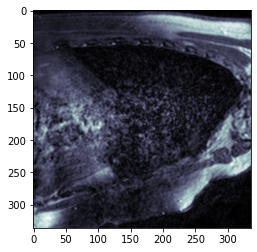

In [58]:
fig = plt.figure()
camera = Camera(fig)

for i in range(processed.shape[-1]):
    plt.imshow(processed[:, :, i], cmap='bone')
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, cmap='autumn', alpha=0.5)
    
    camera.snap()
    
animation = camera.animate()

In [59]:
HTML(animation.to_html5_video())

/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hacen/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2
